In [266]:
# data analysis stack
import numpy as np
import pandas as pd

import func_lib as fun
import statsmodels.api as sma
# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)

import pickle

from scipy import signal
from sklearn.impute import SimpleImputer
# time-related stack
from datetime import datetime as dt

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge, Lasso

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import pmdarima as pm

from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

from scipy.signal import savgol_filter
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [267]:

def qcd_variance(series,window=10):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    
    # first quartile
    Q1 = np.percentile(variances, 25, method='midpoint')
    
    # third quartile
    Q3 = np.percentile(variances, 75, method='midpoint')
    
    # quartile coefficient of dispersion 
    qcd = (Q3-Q1)/(Q3+Q1)
    
    return round(qcd,6)




def p_values(series):
    """
    returns p-values for ADF and KPSS Tests on a time series with explanation
    """

    # Explanation: p value from Augmented Dickey-Fuller (ADF) Test

    p_adf = adfuller(series, autolag="AIC")[1]
    result = adfuller(series, autolag="AIC")
    print(result)

    print('ADF Test Statistic: %.2f' % result[0])
    print('5%% Critical Value: %.2f' % result[4]['5%'])

    if  p_adf<=0.05 or abs(result[0])>abs(result[0]):    #or the absolute value of the test statistics is greater than the critical value
        print('ADF test. P-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, the time series is STATIONARY')
    else:
        print('Time series is NOT STATIONARY') 
        
    print('p-value: %.6f' % result[1])
    
    # Explanation: p value from Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

    p_kpss = kpss(series, regression="c", nlags="auto")[1]
    result = kpss(series)
    print(result)
    
    print('KPSS Test Statistic: %.2f' % result[0])
    print('5%% Critical Value: %.2f' % result[3]['5%'])

    if  p_kpss<=0.05 or abs(result[0])>abs(result[0]):    #or the absolute value of the test statistics is greater than the critical value
        print('KPSS test.  p-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, the time series is NOT STATIONARY.')
    else:
        print('Time series is STATIONARY')

    print('p-value: %.6f' % result[1])

    
    return round(p_adf,6), round(p_kpss,6)



def test_stationarity(series):
    """
    returns likely conclusions about series stationarity
    """
    # test heteroscedasticity with qcd
    qcd = qcd_variance(series)
    
    if qcd >= 0.50:
        print(f"\n non-stationary: heteroscedastic (qcd = {qcd}) \n")
    
    # test stationarity
    else:
        p_adf, p_kpss = p_values(series)
        
        # print p-values
        print( f"\n p_adf: {p_adf}, p_kpss: {p_kpss}" )

        
        if (p_adf < 0.01) and (p_kpss >= 0.05):
            print('\n stationary or seasonal-stationary')
            
        elif (p_adf >= 0.1) and (p_kpss < 0.05):
            print('\n difference-stationary')
            
        elif (p_adf < 0.1) and (p_kpss < 0.05):
            print('\n trend-stationary')
        
        else:
            print('\n non-stationary; no robust conclusions\n')

In [268]:
train = pd.read_csv('train_temp.csv', index_col=0, skipinitialspace = True, parse_dates = [0])

In [269]:
train = train.iloc [0:-1]
train

,TEMP
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2022-12-27,3.9
2022-12-28,6.1
2022-12-29,9.5


In [270]:
decompose = seasonal_decompose(train, 
                                model='additive', 
                                filt=None, 
                                period = 365, 
                                two_sided=True, 
                                extrapolate_trend=1)

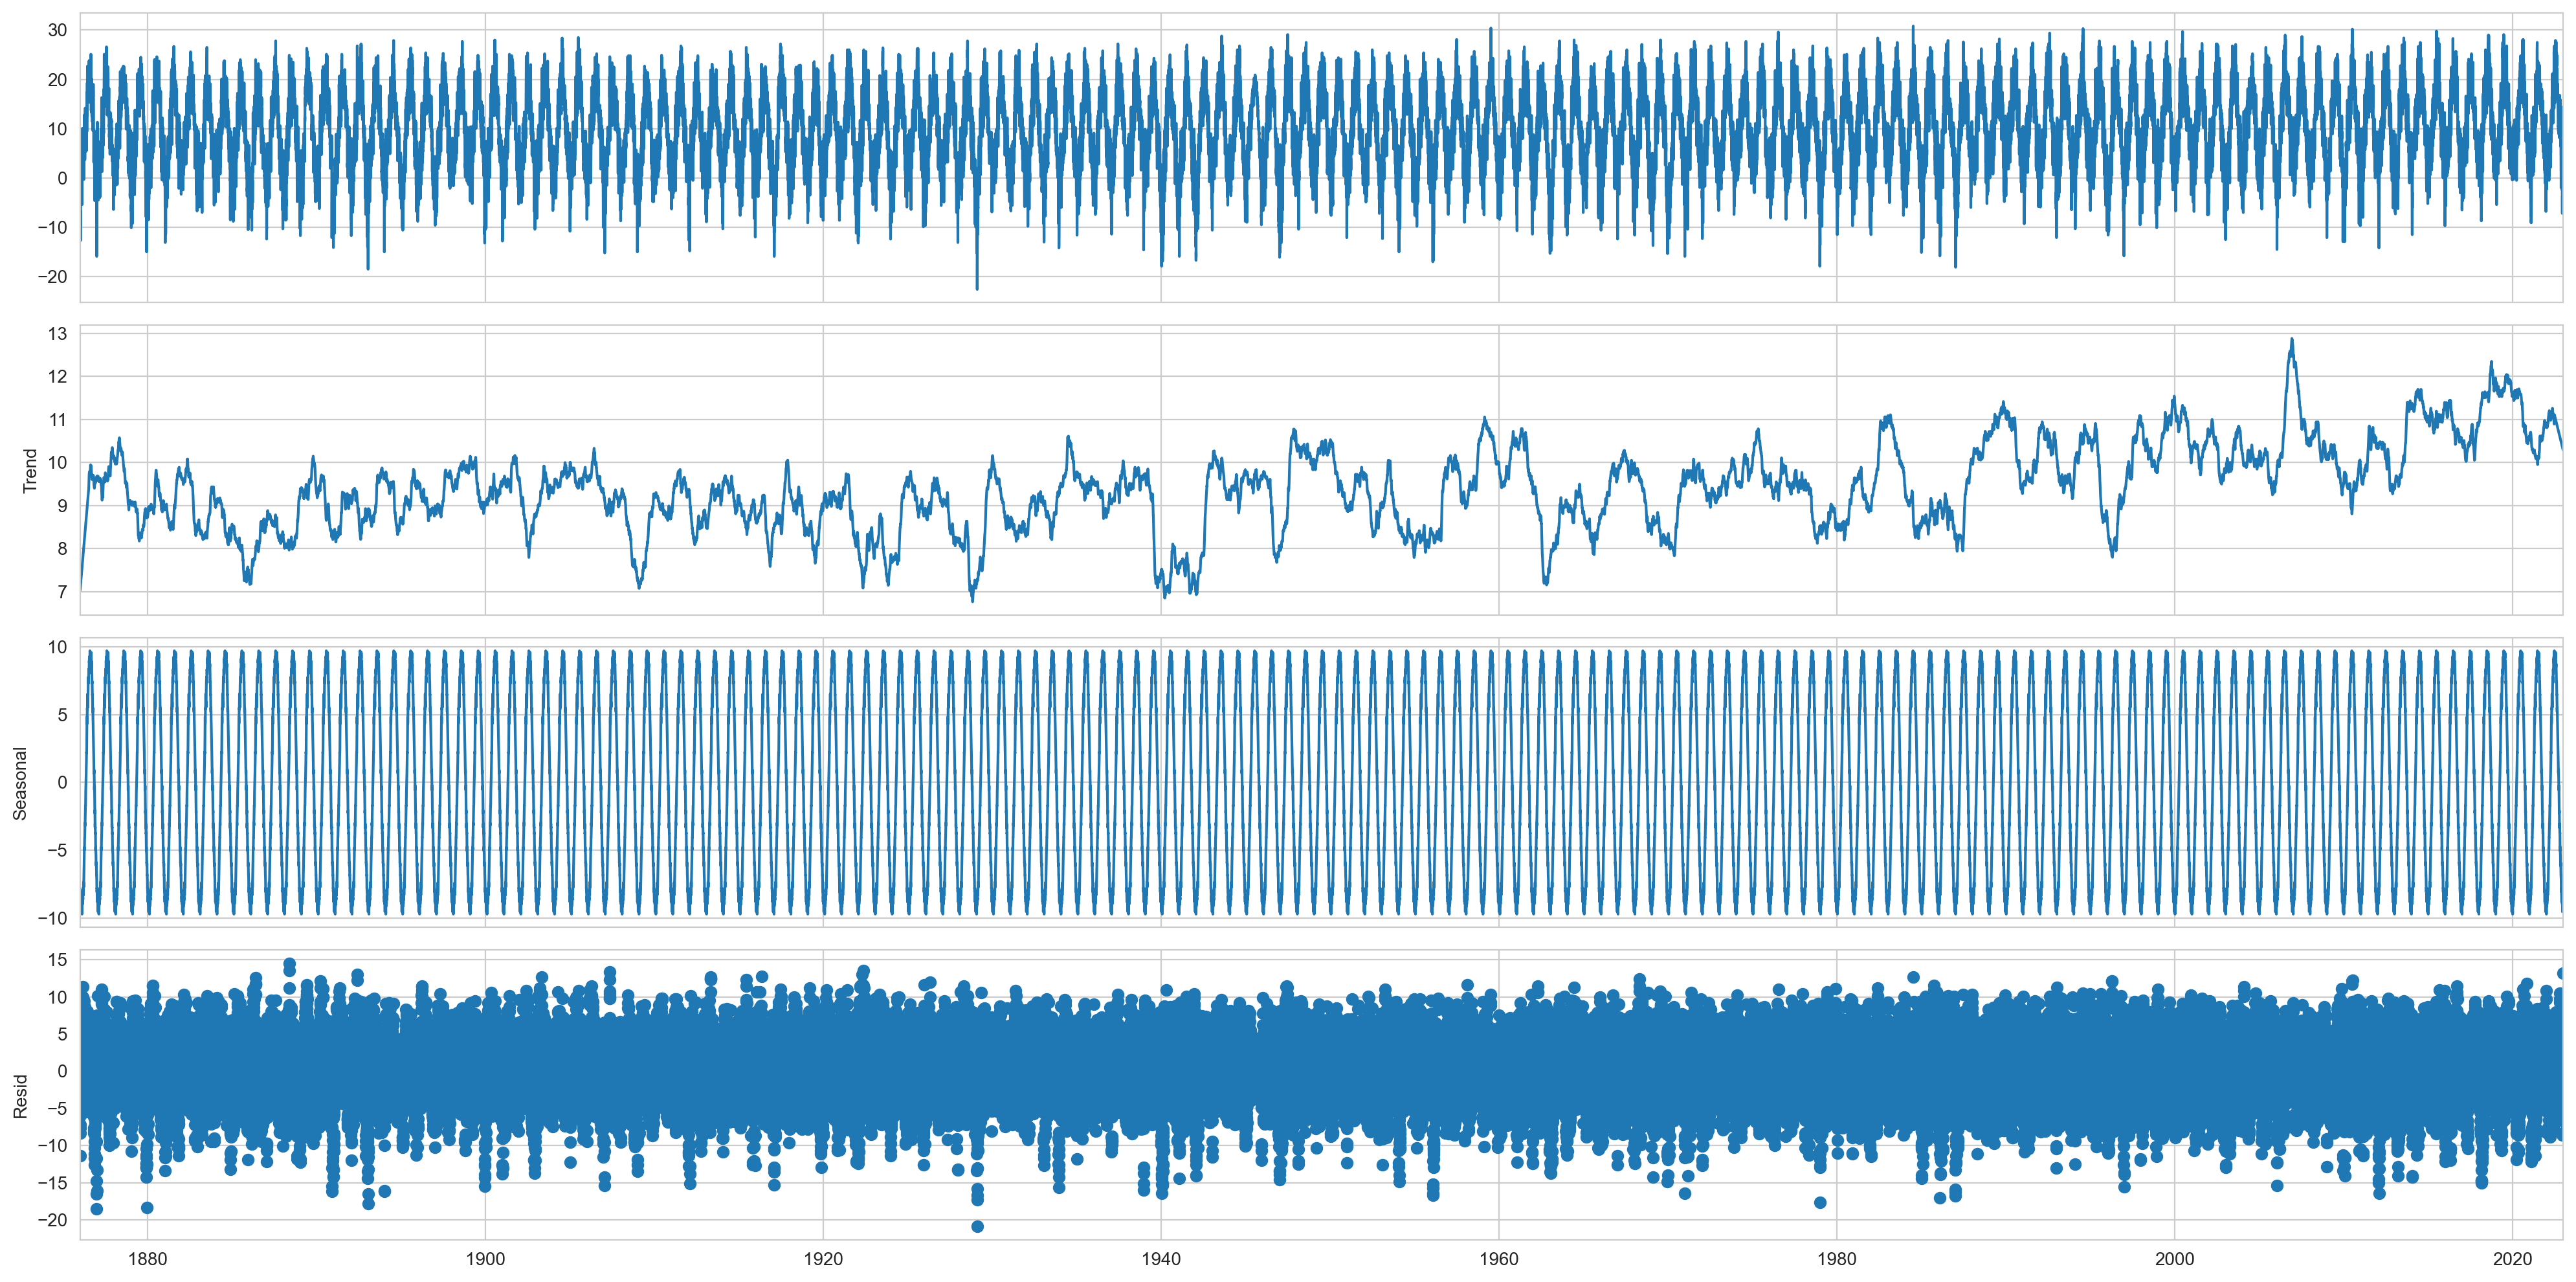

In [271]:
rcParams['figure.figsize'] = 20, 10

decompose.plot()

plt.show()

In [272]:
train['seasonal'] = decompose.seasonal
train['resid'] =  decompose.resid
train['trend'] = decompose.trend
train_trend = train['trend']


train['signal'] = savgol_filter(np.array(train['TEMP']), 99, 3, mode='nearest')
train['high_freq'] = train['TEMP'] - train['signal']


In [273]:
decompose_trend = seasonal_decompose(train_trend, 
                                model='addictive', 
                                filt=None, 
                                period = 5000, 
                                two_sided=True, 
                                extrapolate_trend=0)

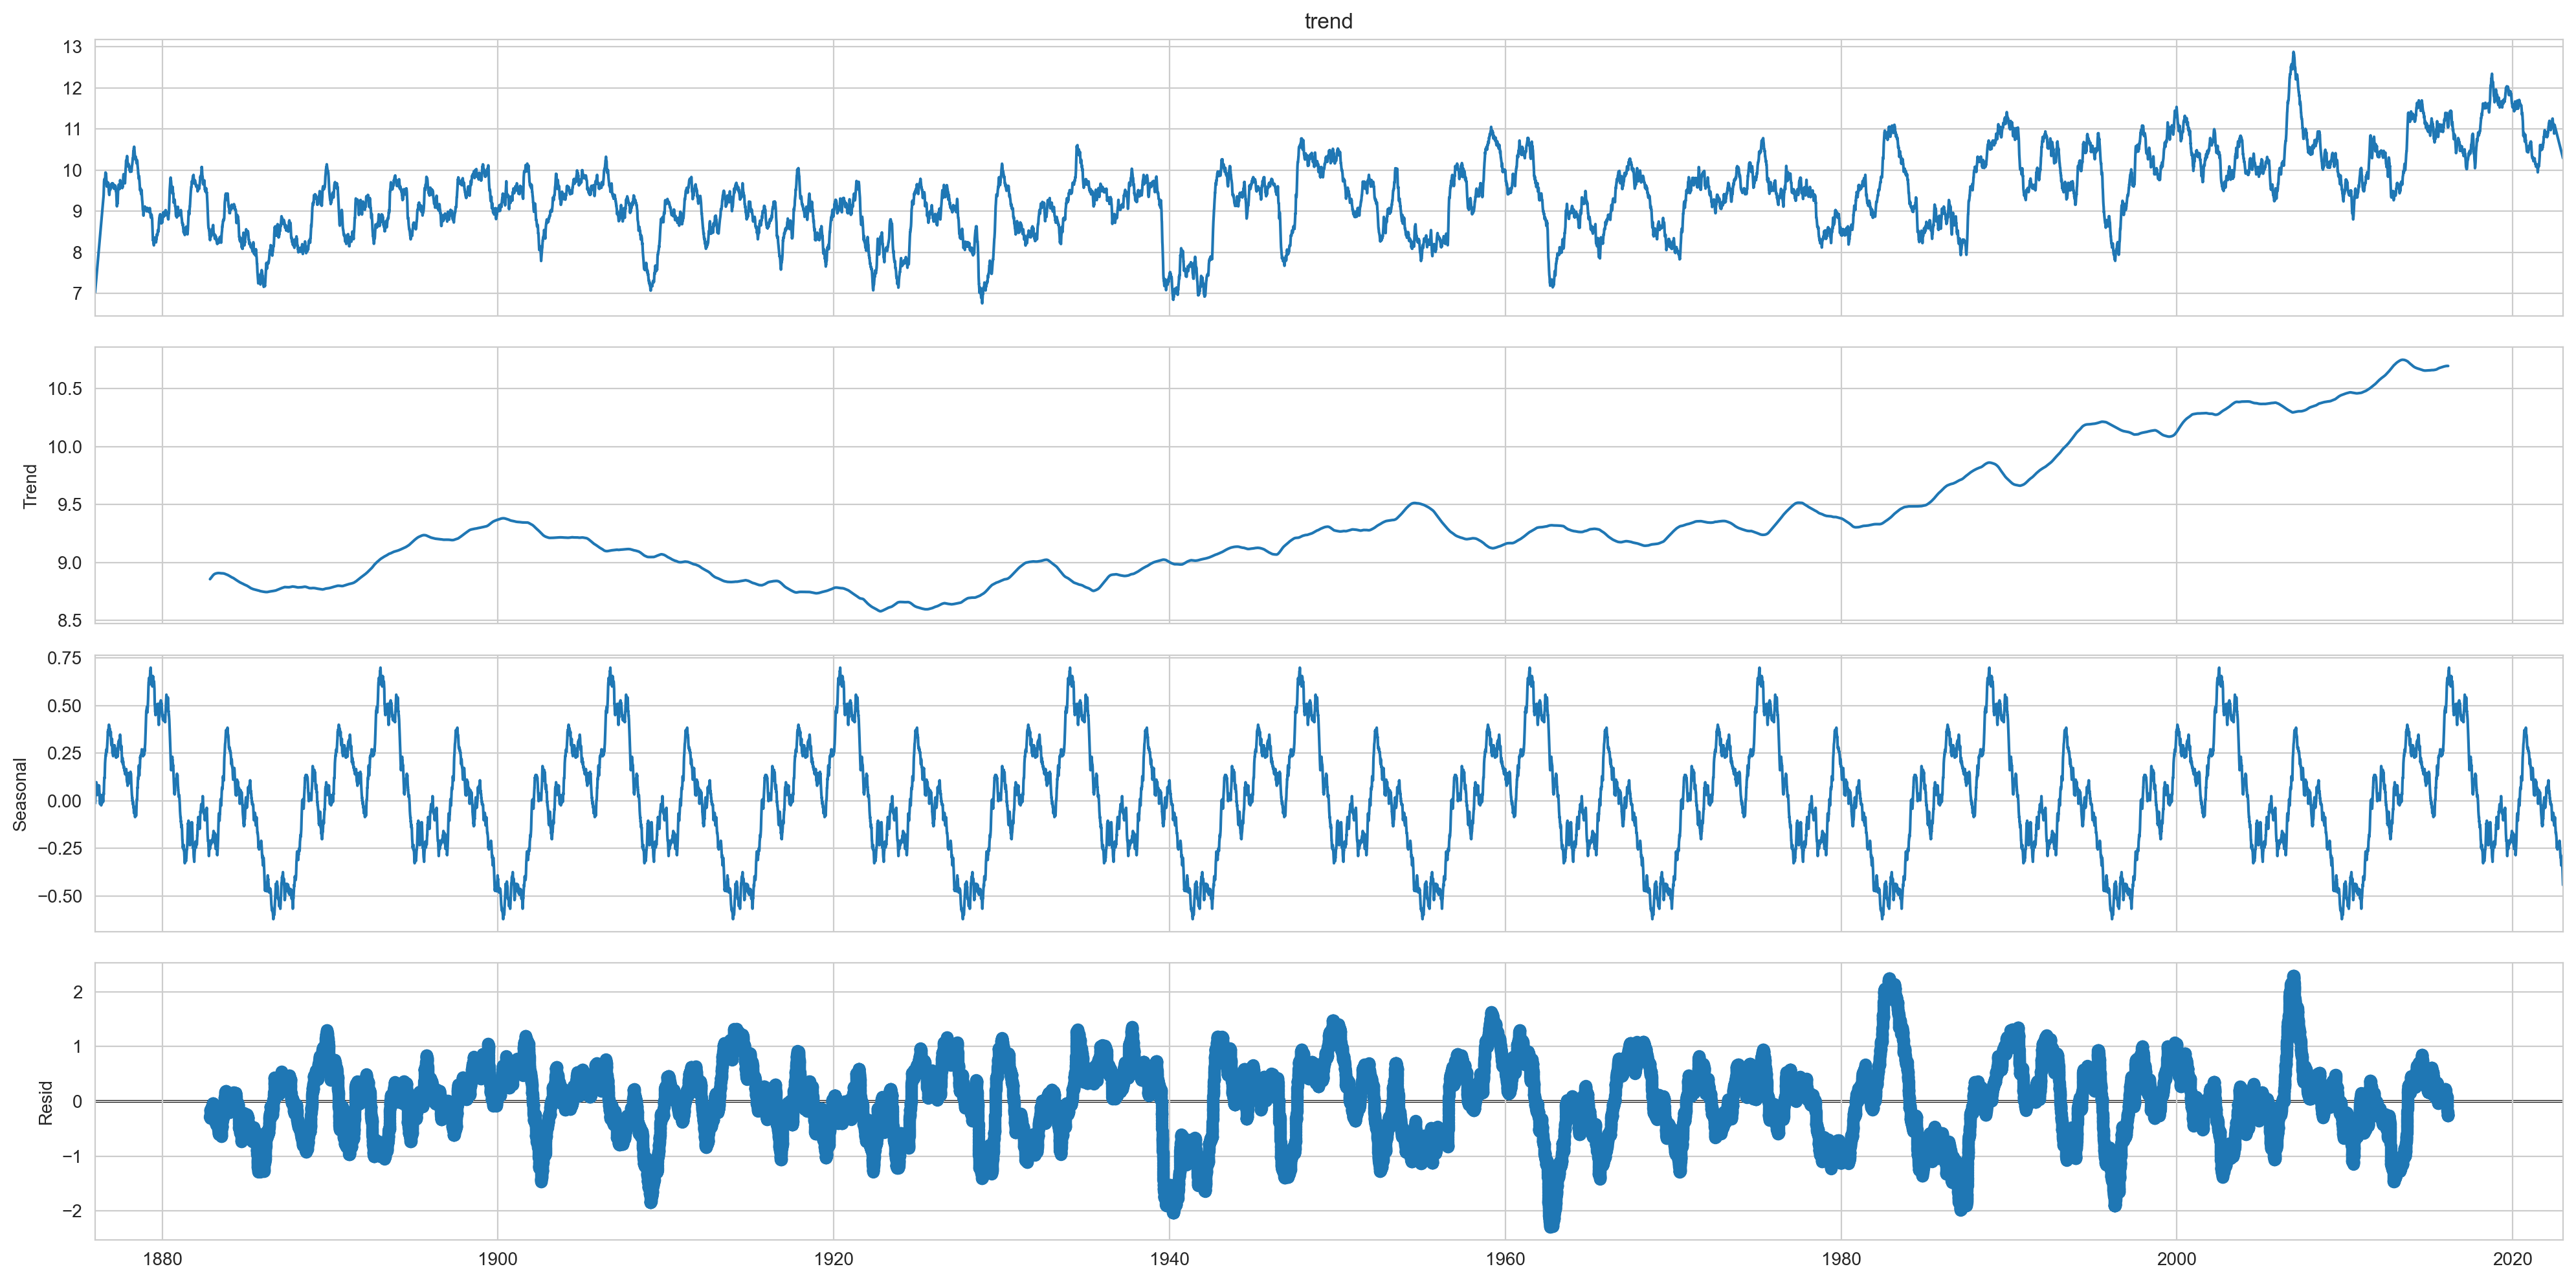

In [274]:
rcParams['figure.figsize'] = 20, 10

decompose_trend.plot()

plt.show()

In [275]:
train['trend_2'] = decompose_trend.trend

In [276]:
X_train = train.reset_index()[['DATE']].iloc[2500:-2500]
y_train = train.reset_index()['trend_2'].iloc[2500:-2500]

In [277]:
y_train.head()

2500    8.854714
2501    8.855234
2502    8.855754
2503    8.856275
2504    8.856797
Name: trend_2, dtype: float64

In [278]:
trend_pipe = make_pipeline(
    # заменяем пропущенные значения на среднее по столбцам
    SimpleImputer(strategy='mean'),
    # обучаем модель линейной регрессии
    Ridge(alpha = 1))
# fit model


In [279]:
trend_model = trend_pipe.fit(X_train, y_train)
trend_model.score

<bound method Pipeline.score of Pipeline(steps=[('simpleimputer', SimpleImputer()), ('ridge', Ridge(alpha=1))])>

In [280]:
X_train = train.reset_index()[['DATE']]
train['trend_model'] = trend_model.predict(X_train)

<Axes: xlabel='DATE'>

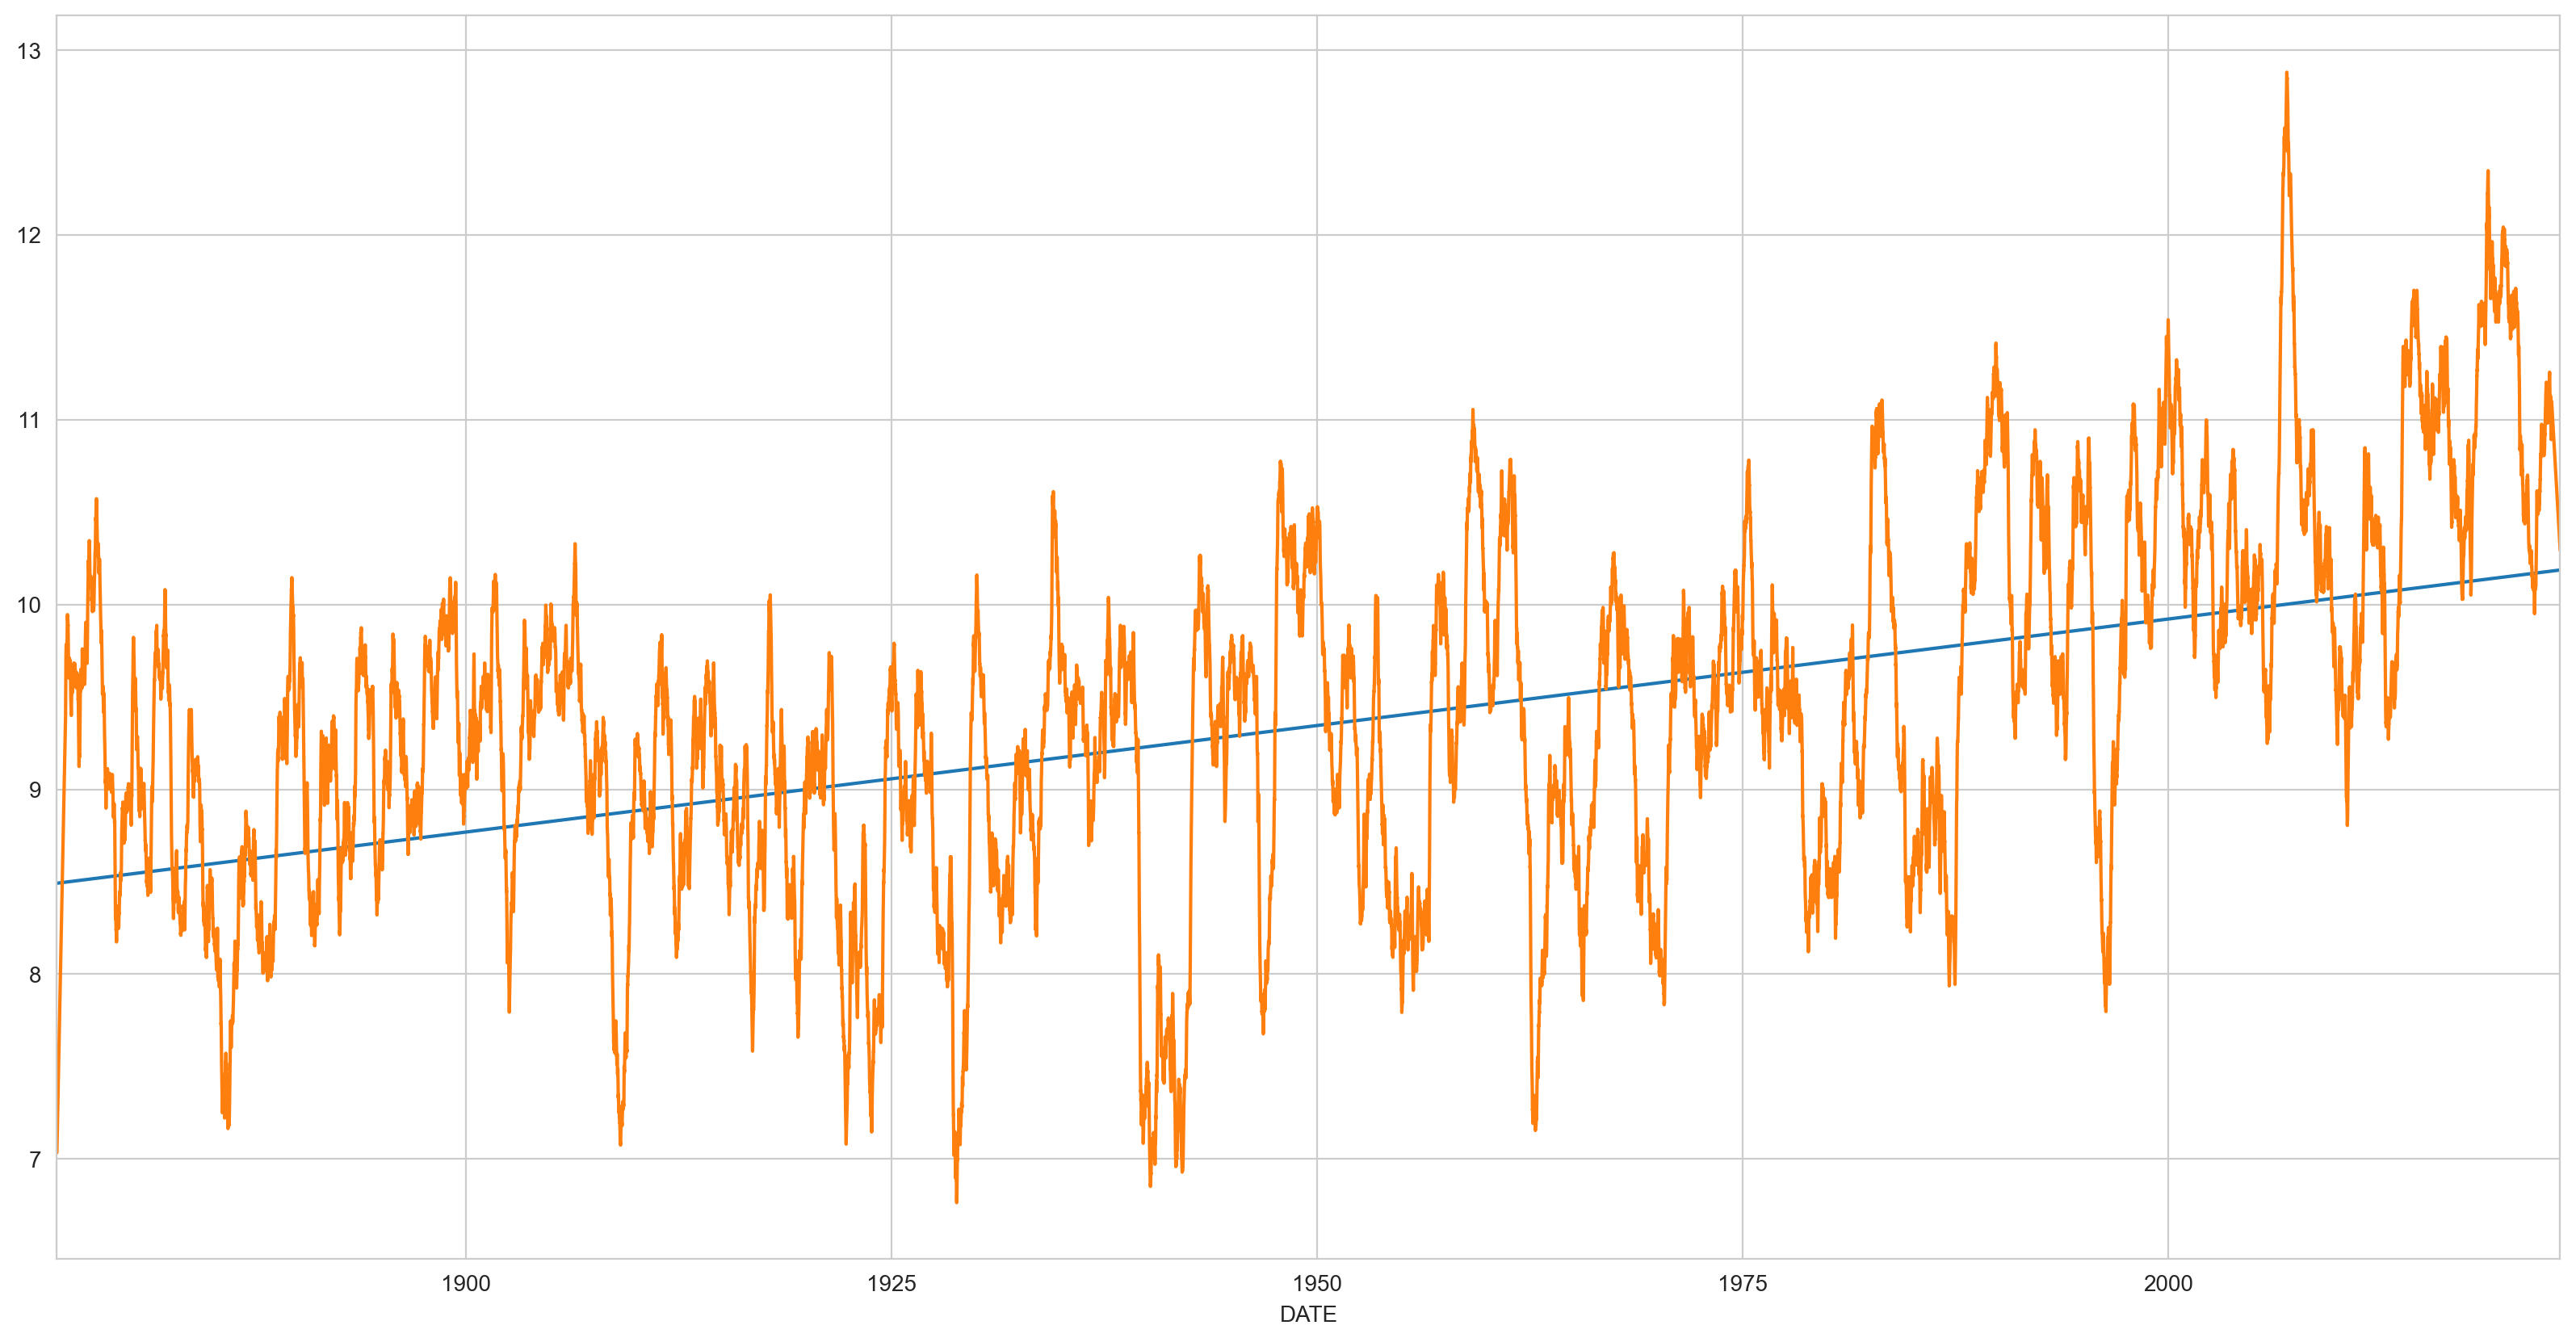

In [281]:
rcParams['figure.figsize'] = 20, 10
train['trend_model'].plot()
train['trend'].plot()


In [282]:
train['detrenned'] = train['signal'] - train['trend_model']
train

,TEMP,seasonal,resid,trend,signal,high_freq,trend_2,trend_model,detrenned
DATE,,,,,,,,,
1876-01-01,2.2,-7.918887,3.085462,7.033425,-0.659391,2.859391,NaN,8.491795,-9.151186
1876-01-02,2.5,-8.103283,3.557256,7.046027,-0.772946,3.272946,NaN,8.491827,-9.264773
1876-01-03,0.3,-8.317410,1.558780,7.058630,-0.858296,1.158296,NaN,8.491858,-9.350154
1876-01-04,-5.8,-8.503137,-4.368096,7.071233,-1.025494,-4.774506,NaN,8.491890,-9.517384
1876-01-05,-9.8,-8.600373,-8.283462,7.083836,-1.151521,-8.648479,NaN,8.491922,-9.643443
...,...,...,...,...,...,...,...,...,...
2022-12-27,3.9,-9.223400,2.813263,10.310137,6.580128,-2.680128,NaN,10.186668,-3.606540
2022-12-28,6.1,-9.314033,5.108280,10.305753,6.964142,-0.864142,NaN,10.186699,-3.222558
2022-12-29,9.5,-9.453289,8.651919,10.301370,7.358739,2.141261,NaN,10.186731,-2.827992


In [283]:
arima_model_noise = pm.auto_arima(
    train['high_freq'],
    start_p=1, 
    start_q=1,
    max_p=1, 
    max_q=1, 
    seasonality = False,
    stationarity =  False,
    d=None,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=237724.569, Time=2.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=281833.845, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=239387.913, Time=0.93 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=250072.858, Time=2.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281831.854, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=237722.570, Time=1.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=250070.864, Time=0.95 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=239385.913, Time=0.29 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 8.361 seconds


In [284]:
arima_model_noise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53691
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -118858.285
Date:                Mon, 15 May 2023   AIC                         237722.570
Time:                        03:23:47   BIC                         237749.243
Sample:                    01-01-1876   HQIC                        237730.897
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6351      0.004    157.175      0.000       0.627       0.643
ma.L1          0.2370      0.005     46.164      0.000       0.227       0.247
sigma2         4.9017      0.027    183.505      0.000       4.849       4.954
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               884.23
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [285]:
arima_model_noise.fit(train['high_freq'])

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [286]:
tr = arima_model_noise.predict(5)
tr

2023-01-01    5.727579
2023-01-02    3.637321
2023-01-03    2.309895
2023-01-04    1.466907
2023-01-05    0.931565
Freq: D, dtype: float64

<Axes: xlabel='DATE'>

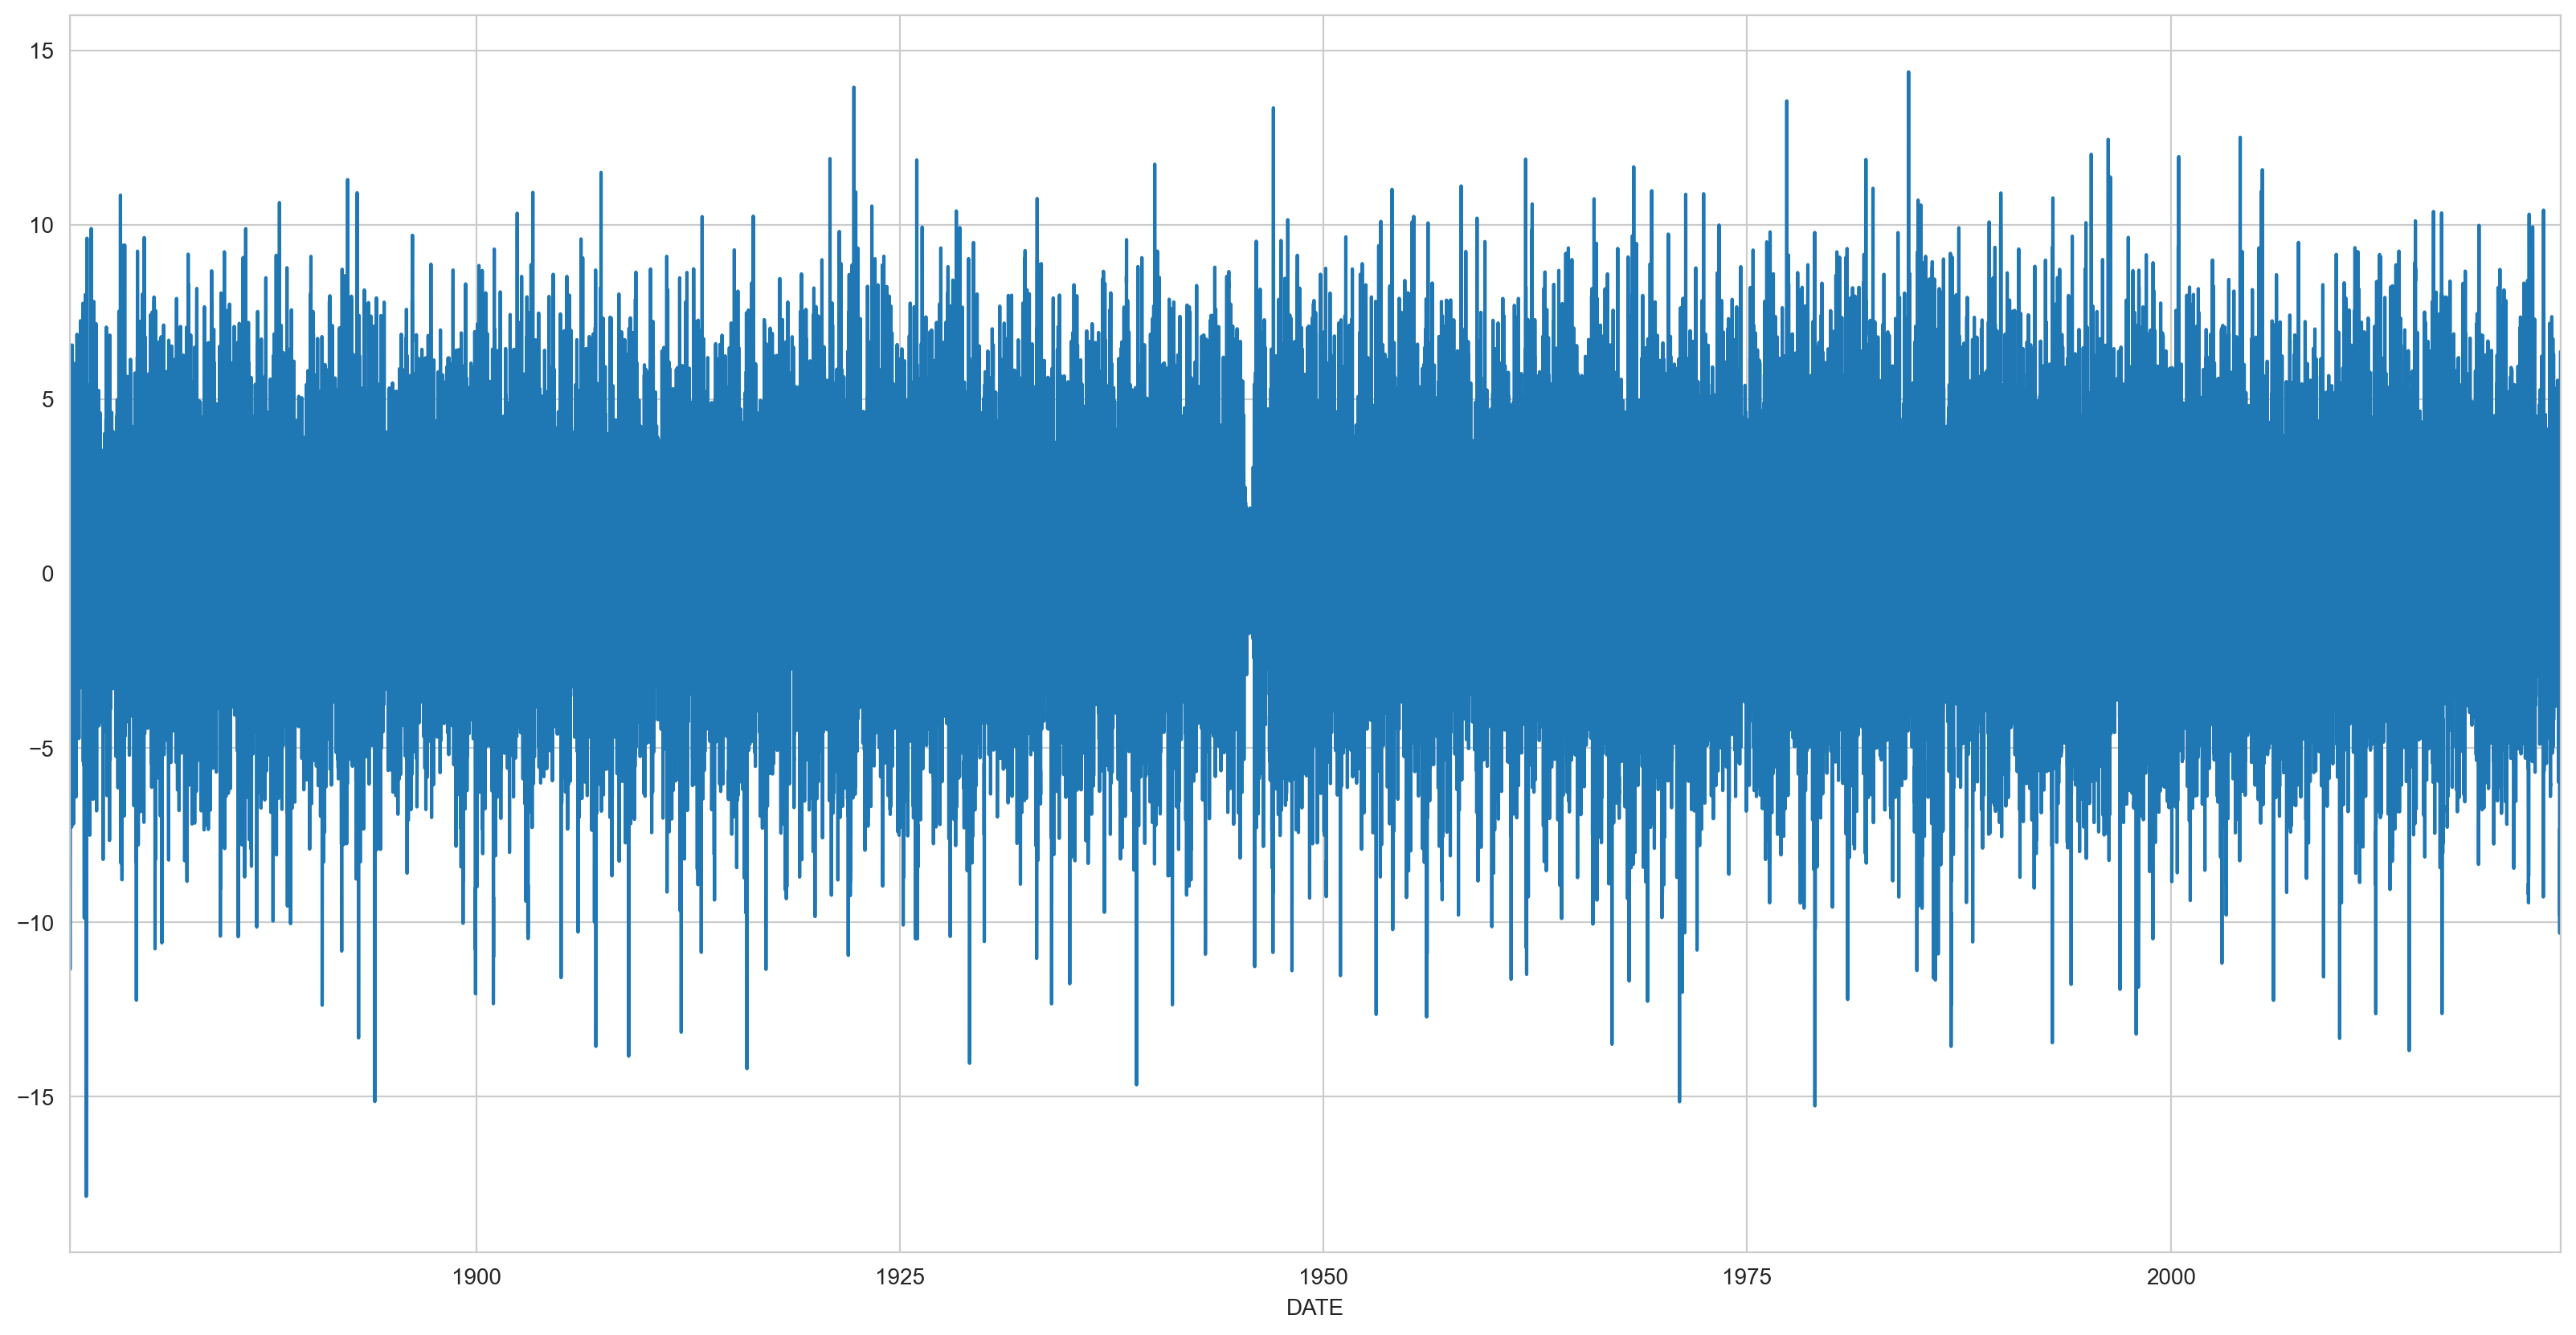

In [287]:
train['high_freq'].plot()

<Axes: xlabel='DATE'>

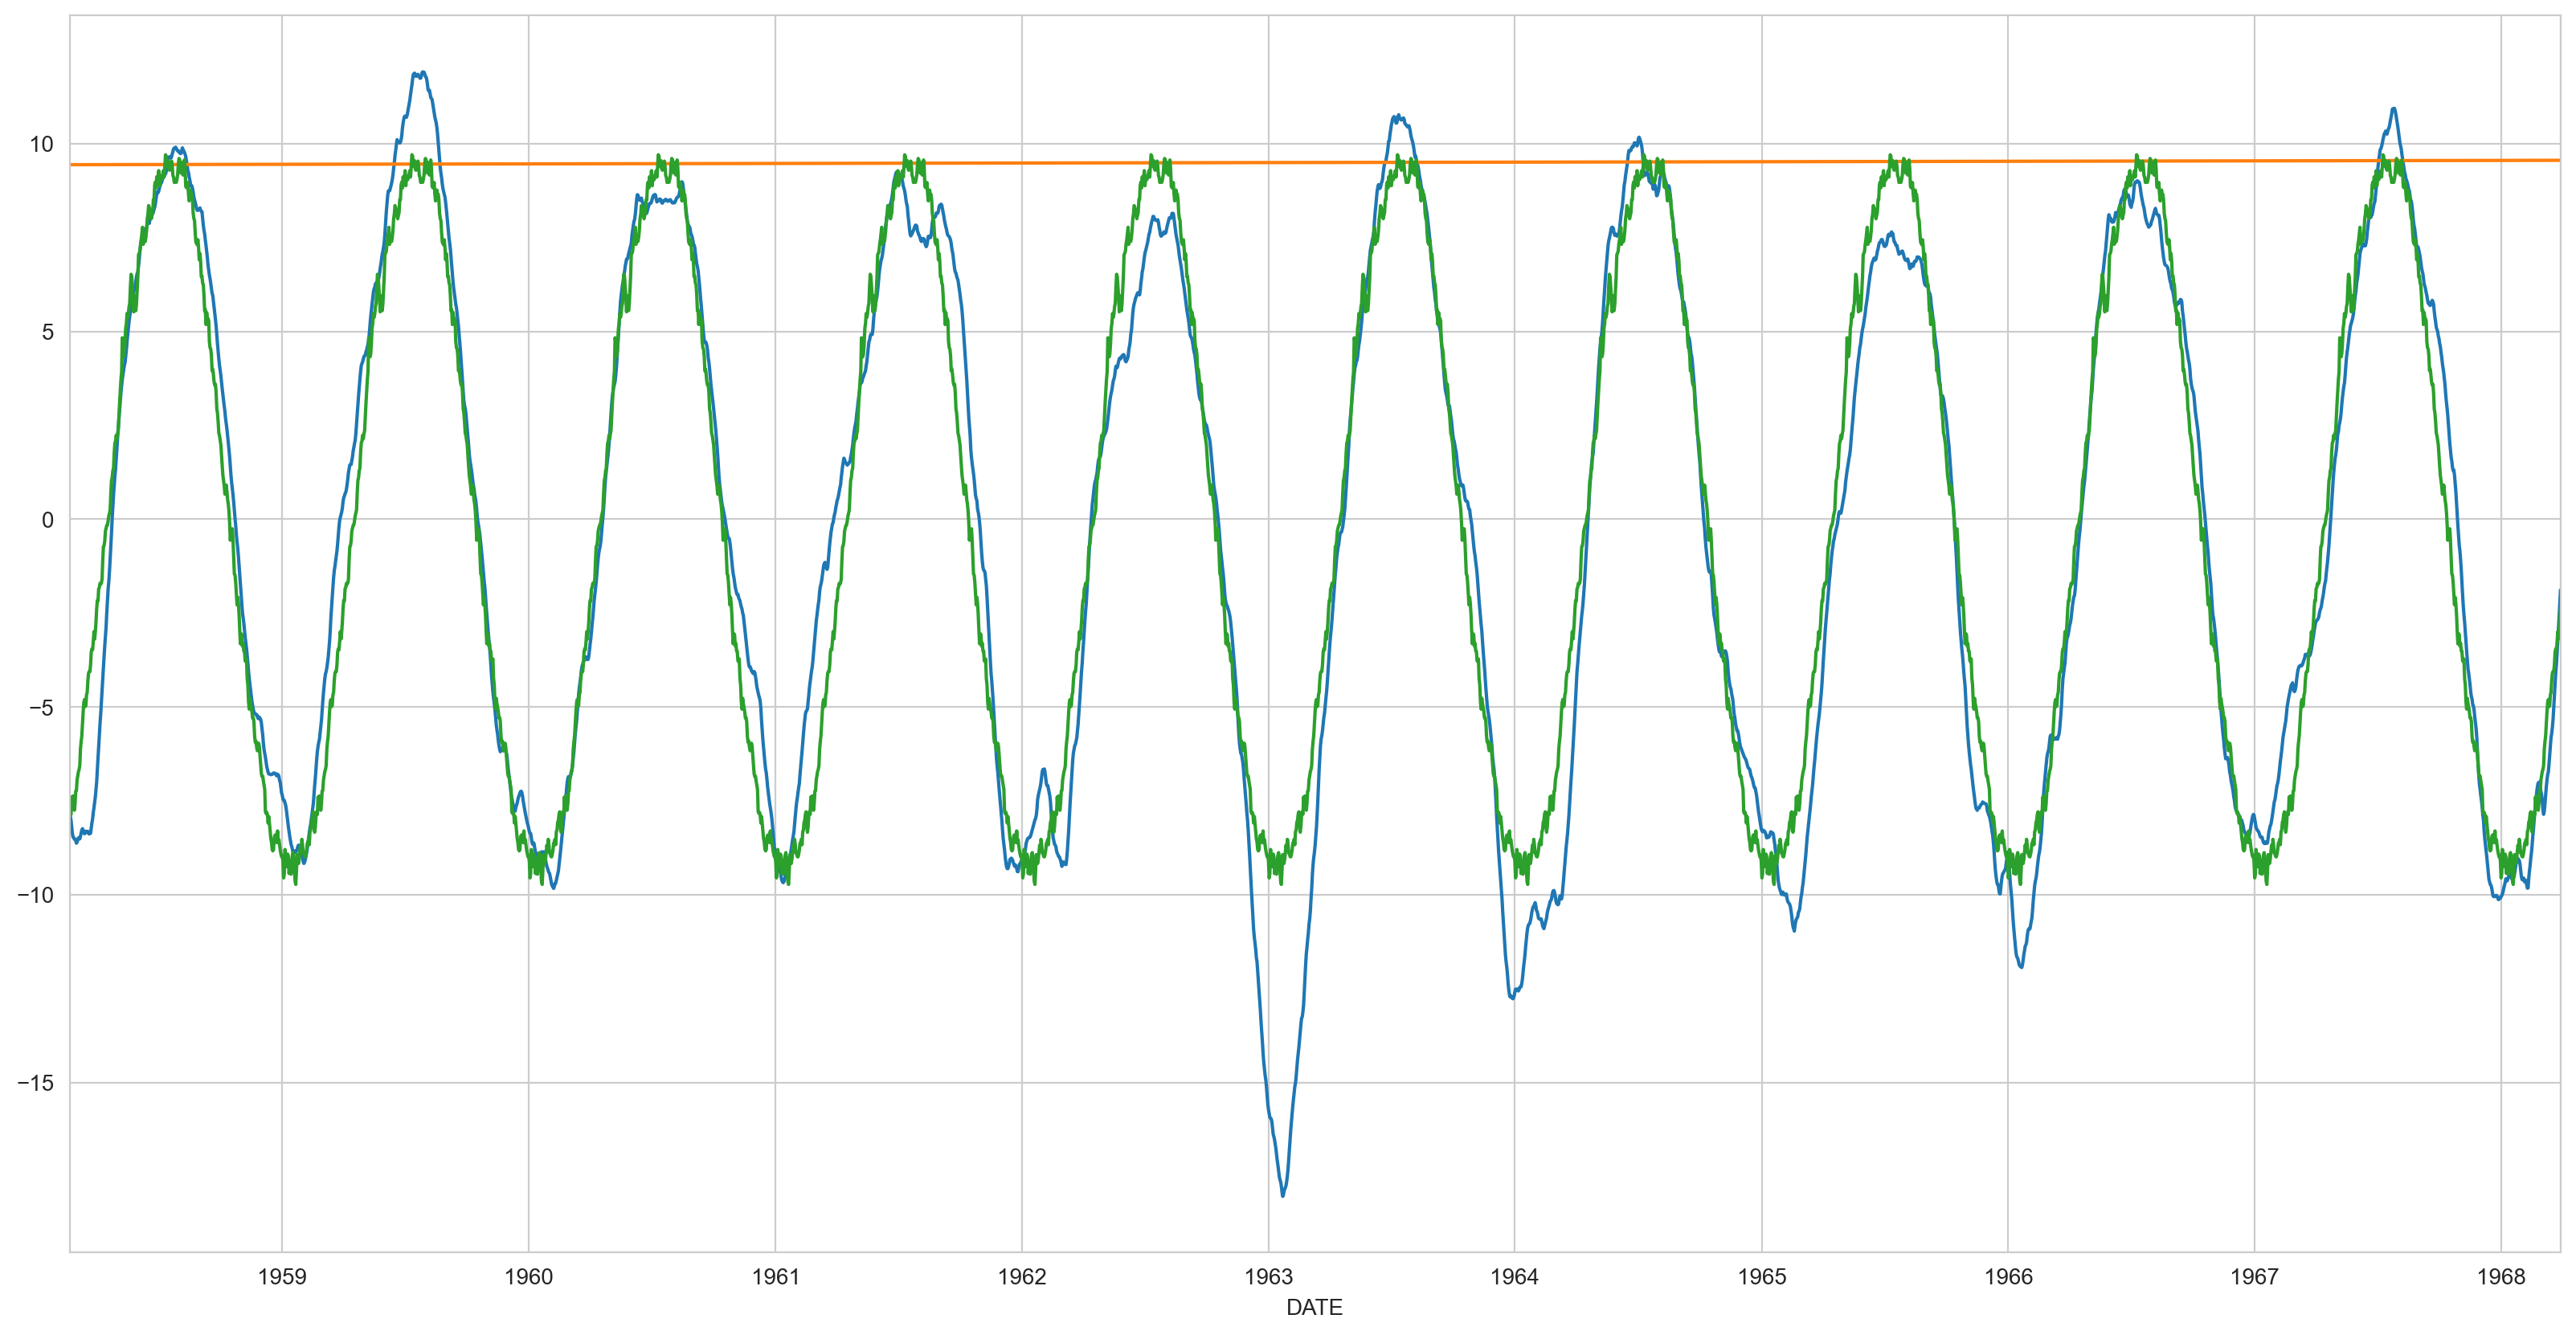

In [288]:
train['detrenned'].iloc[30000:-20000].plot()
train['trend_model'].iloc[30000:-20000].plot()
train['seasonal'].iloc[30000:-20000].plot()

### Frequency analisys

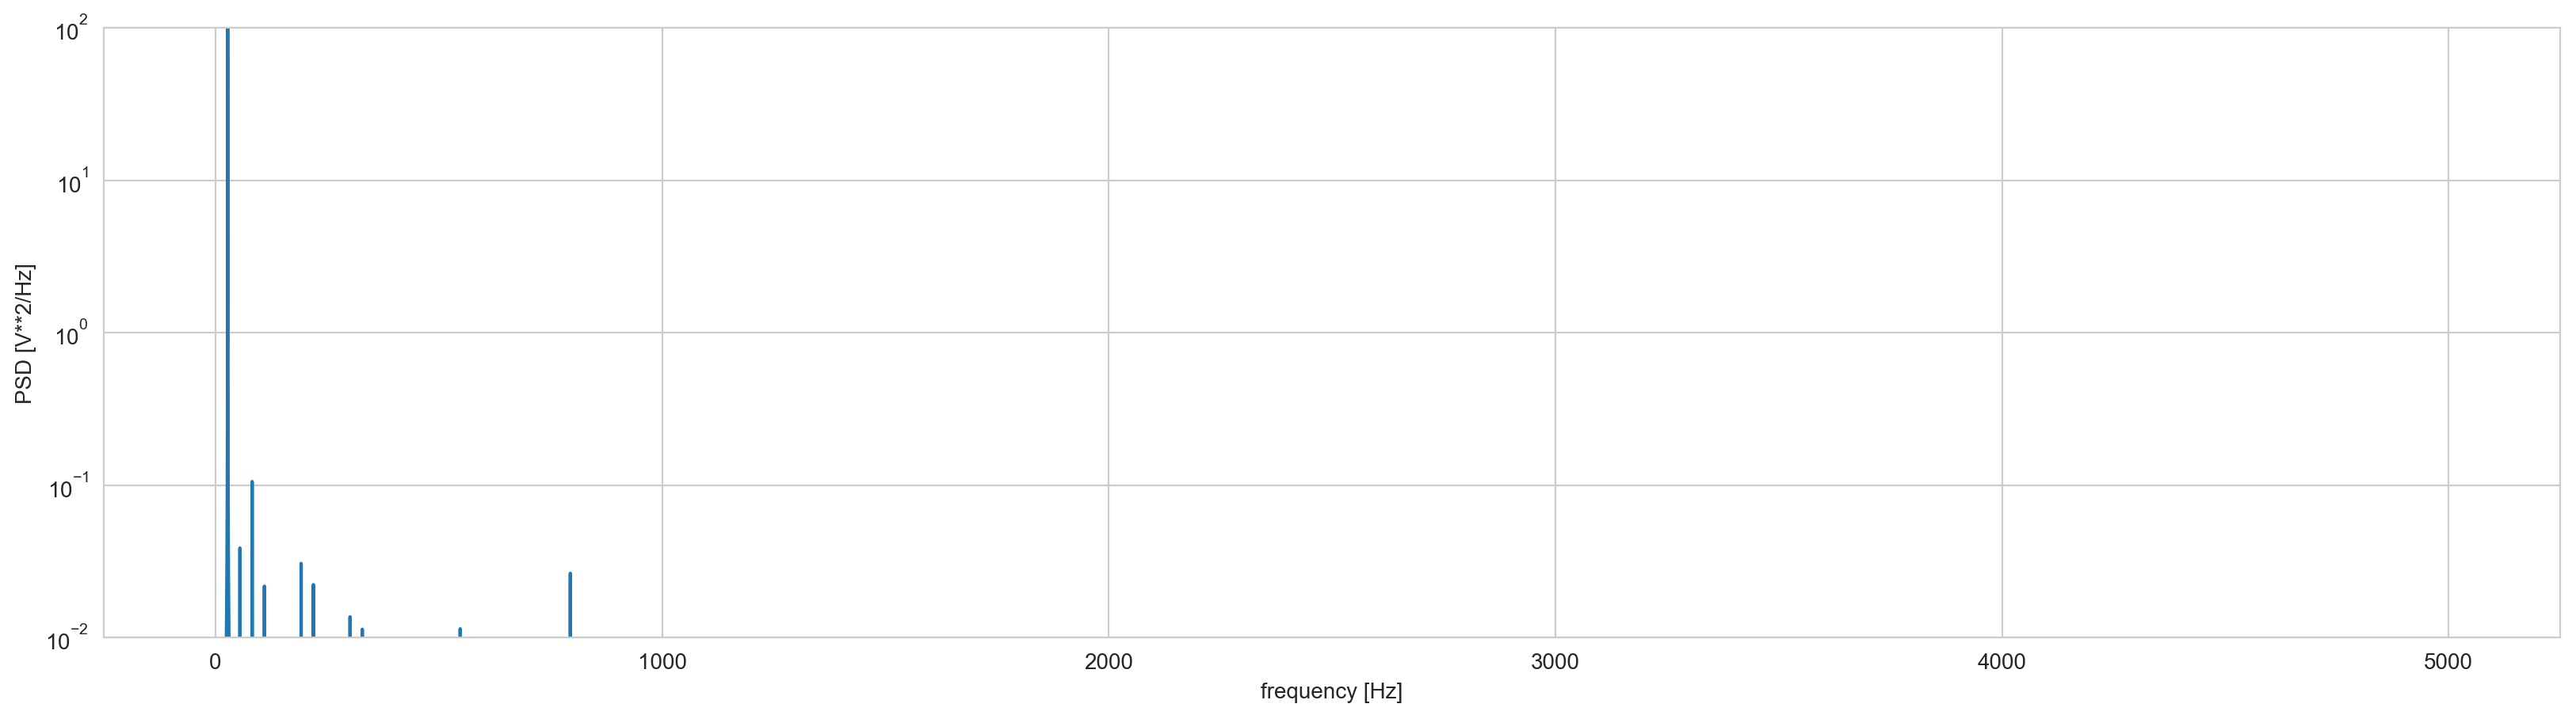

In [289]:
rcParams['figure.figsize'] = 20,5
fs = 10000
f, Pxx_den = signal.periodogram(train['seasonal'], fs)
plt.semilogy(f, Pxx_den)
plt.ylim([0.01, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

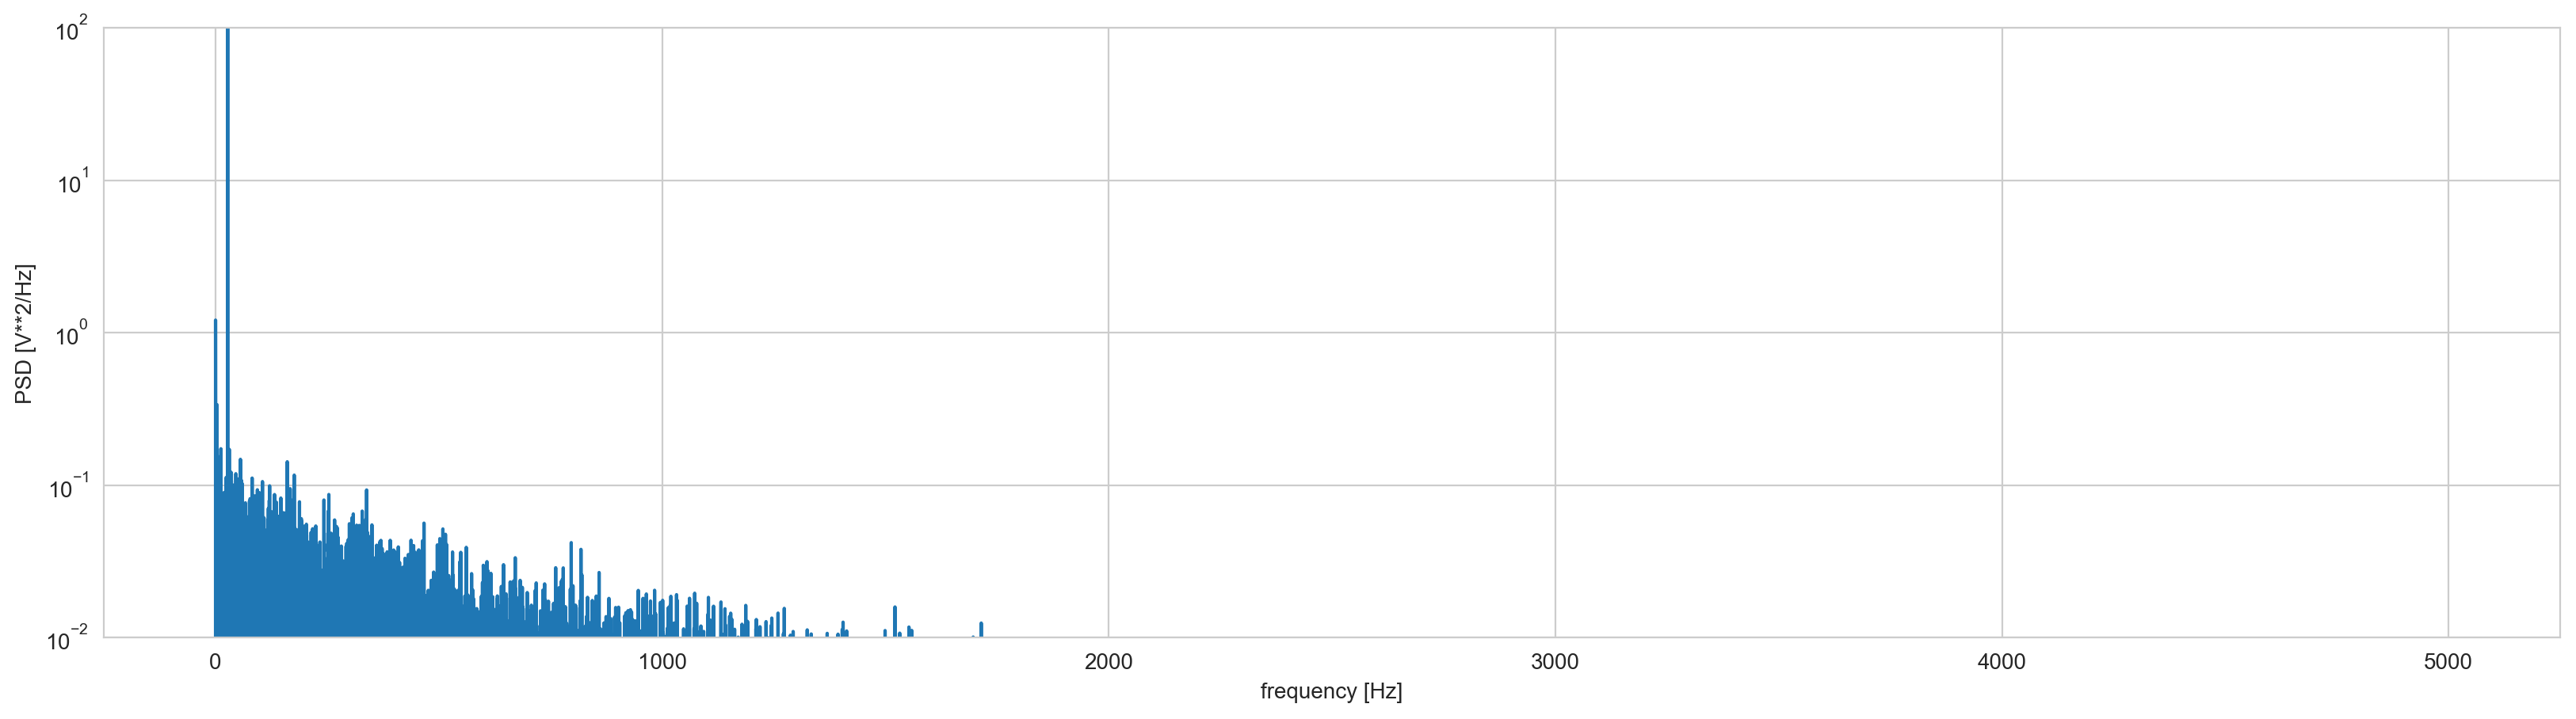

In [290]:
rcParams['figure.figsize'] = 20,5
f, Pxx_den = signal.periodogram(train['TEMP'], fs)
plt.semilogy(f, Pxx_den)
plt.ylim([0.01, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

<Axes: xlabel='DATE'>

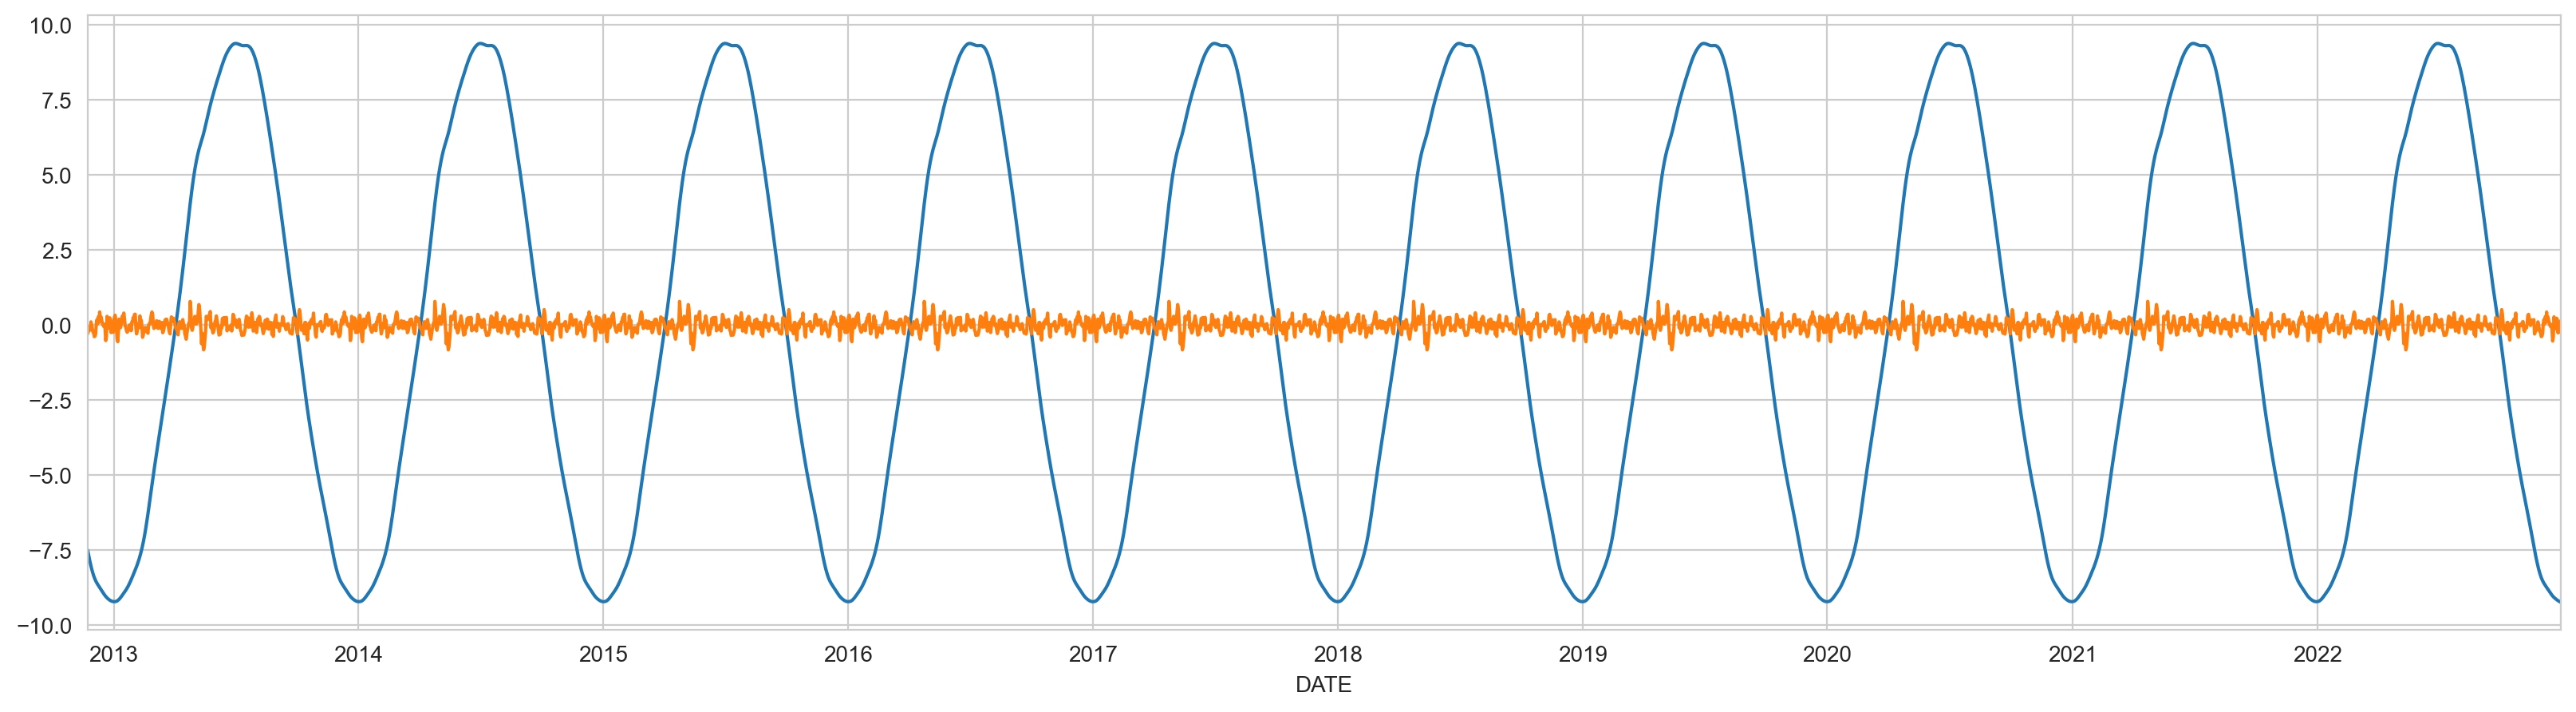

In [291]:
train['hp'], train['cycle'] = sma.tsa.filters.hpfilter(train['seasonal'], 1000)
train['cycle'].iloc[50000:-1].plot()
train['hp'].iloc[50000:-1].plot()

In [292]:
# auto-correlation plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

def auto_correlation_plot(series):
    """
    plots autocorrelations for a given series
    """
    mpl.rc('figure', figsize=(10,2), dpi=200)
    plot_acf(series, zero=False, lags=25)
    plt.xlabel('number of lags')
    plt.ylabel('autocorrelation')
    plt.show()

# partial auto-corremation plot 

def partial_auto_correlation_plot(series):
    """
    plots partial autocorrelations for a given series
    """
    mpl.rc('figure', figsize=(10,2), dpi=200)
    plot_pacf(series, zero=False, lags=25)
    plt.xlabel('number of lags')
    plt.ylabel('partial autocorrelation')

In [293]:
train

,TEMP,seasonal,resid,trend,signal,high_freq,trend_2,trend_model,detrenned,hp,cycle
DATE,,,,,,,,,,,
1876-01-01,2.2,-7.918887,3.085462,7.033425,-0.659391,2.859391,NaN,8.491795,-9.151186,0.336469,-8.255356
1876-01-02,2.5,-8.103283,3.557256,7.046027,-0.772946,3.272946,NaN,8.491827,-9.264773,0.192516,-8.295800
1876-01-03,0.3,-8.317410,1.558780,7.058630,-0.858296,1.158296,NaN,8.491858,-9.350154,0.018497,-8.335907
1876-01-04,-5.8,-8.503137,-4.368096,7.071233,-1.025494,-4.774506,NaN,8.491890,-9.517384,-0.127989,-8.375148
1876-01-05,-9.8,-8.600373,-8.283462,7.083836,-1.151521,-8.648479,NaN,8.491922,-9.643443,-0.187397,-8.412977
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,3.9,-9.223400,2.813263,10.310137,6.580128,-2.680128,NaN,10.186668,-3.606540,-0.032887,-9.190513
2022-12-28,6.1,-9.314033,5.108280,10.305753,6.964142,-0.864142,NaN,10.186699,-3.222558,-0.110084,-9.203949
2022-12-29,9.5,-9.453289,8.651919,10.301370,7.358739,2.141261,NaN,10.186731,-2.827992,-0.236825,-9.216464


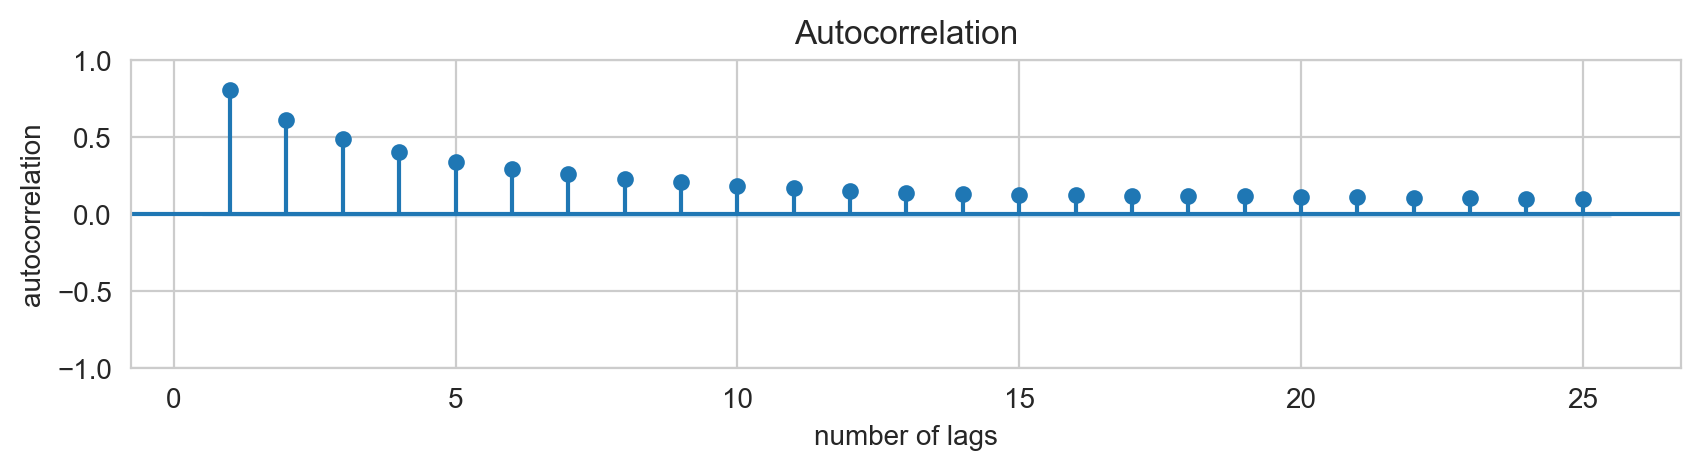

In [294]:
auto_correlation_plot(train['resid'])

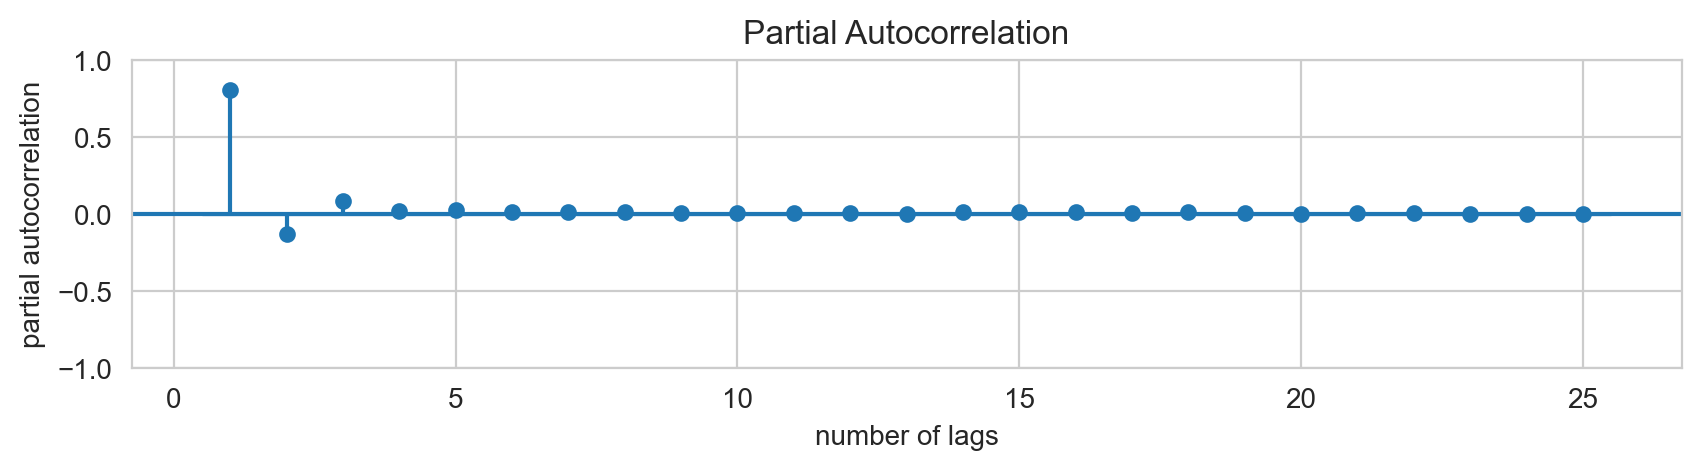

In [295]:
partial_auto_correlation_plot(train['resid'])

In [296]:

stepwise_model = pm.auto_arima(
    train['cycle'].iloc[53000:],
    seasonal = True,
    stationary = False,
    d=None,
    m=24,
    trace = True,
    trend=None, 
    n_jobs=-1
)



Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[24]             : AIC=inf, Time=1.42 sec
 ARIMA(0,2,0)(0,0,0)[24]             : AIC=-5914.703, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[24]             : AIC=-8351.717, Time=0.51 sec
 ARIMA(0,2,1)(0,0,1)[24]             : AIC=-6851.788, Time=0.91 sec
 ARIMA(1,2,0)(0,0,0)[24]             : AIC=-8341.793, Time=0.05 sec
 ARIMA(1,2,0)(2,0,0)[24]             : AIC=-8292.033, Time=1.87 sec
 ARIMA(1,2,0)(1,0,1)[24]             : AIC=inf, Time=1.07 sec
 ARIMA(1,2,0)(0,0,1)[24]             : AIC=-8352.488, Time=1.10 sec
 ARIMA(1,2,0)(0,0,2)[24]             : AIC=-8337.793, Time=0.89 sec
 ARIMA(1,2,0)(1,0,2)[24]             : AIC=-8341.573, Time=3.10 sec
 ARIMA(0,2,0)(0,0,1)[24]             : AIC=-5924.858, Time=0.65 sec
 ARIMA(2,2,0)(0,0,1)[24]             : AIC=inf, Time=0.93 sec
 ARIMA(1,2,1)(0,0,1)[24]             : AIC=inf, Time=0.73 sec
 ARIMA(2,2,1)(0,0,1)[24]             : AIC=inf, Time=0.83 sec
 ARIMA(1,2,0)(0,0,1)[24] intercept 

In [297]:
stepwise_model.fit(train['cycle'])

ARIMA(order=(1, 2, 0), scoring_args={}, seasonal_order=(0, 0, 1, 24),
      suppress_warnings=True, with_intercept=False)

In [298]:
train

,TEMP,seasonal,resid,trend,signal,high_freq,trend_2,trend_model,detrenned,hp,cycle
DATE,,,,,,,,,,,
1876-01-01,2.2,-7.918887,3.085462,7.033425,-0.659391,2.859391,NaN,8.491795,-9.151186,0.336469,-8.255356
1876-01-02,2.5,-8.103283,3.557256,7.046027,-0.772946,3.272946,NaN,8.491827,-9.264773,0.192516,-8.295800
1876-01-03,0.3,-8.317410,1.558780,7.058630,-0.858296,1.158296,NaN,8.491858,-9.350154,0.018497,-8.335907
1876-01-04,-5.8,-8.503137,-4.368096,7.071233,-1.025494,-4.774506,NaN,8.491890,-9.517384,-0.127989,-8.375148
1876-01-05,-9.8,-8.600373,-8.283462,7.083836,-1.151521,-8.648479,NaN,8.491922,-9.643443,-0.187397,-8.412977
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,3.9,-9.223400,2.813263,10.310137,6.580128,-2.680128,NaN,10.186668,-3.606540,-0.032887,-9.190513
2022-12-28,6.1,-9.314033,5.108280,10.305753,6.964142,-0.864142,NaN,10.186699,-3.222558,-0.110084,-9.203949
2022-12-29,9.5,-9.453289,8.651919,10.301370,7.358739,2.141261,NaN,10.186731,-2.827992,-0.236825,-9.216464


In [299]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                53691
Model:             SARIMAX(1, 2, 0)x(0, 0, [1], 24)   Log Likelihood              325875.726
Date:                              Mon, 15 May 2023   AIC                        -651745.451
Time:                                      03:24:54   BIC                        -651718.778
Sample:                                  01-01-1876   HQIC                       -651737.124
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9853      0.001   1246.793      0.000       0.984       0.987
ma.S.L24    1.316e-07      0.005    2.9e-05      1.000      -0.009       0.009
sigma2      3.124e-07   1.49e-09    209.486      0.000    3.09e-07    3.15e-07
===================================================================================
Ljung-Box (L1) (Q):               45647.39   Jarque-Bera (JB):              4540.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.03
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [300]:
test_stationarity(train['cycle'])


 non-stationary: heteroscedastic (qcd = 0.810603) 



In [301]:
test_stationarity(train['high_freq'])

(-60.428880721491055, 0.0, 58, 53632, {'1%': -3.430471934908495, '5%': -2.861593892805775, '10%': -2.5667986853441125}, 233567.92621642415)
ADF Test Statistic: -60.43
5% Critical Value: -2.86
ADF test. P-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, the time series is STATIONARY
p-value: 0.000000
(0.0003314797269412315, 0.1, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.00
5% Critical Value: 0.46
Time series is STATIONARY
p-value: 0.100000

 p_adf: 0.0, p_kpss: 0.1

 stationary or seasonal-stationary


In [302]:
train['reminder'] = train['detrenned'] - train['cycle'] 
test_stationarity(train['reminder'])


 non-stationary: heteroscedastic (qcd = 0.771538) 



In [303]:
reminder_sarima_model = pm.auto_arima(train['reminder'],
                           start_p=0,  
                           start_q=0,
                           max_p=2, 
                           max_q=2, 
                           start_P=0, 
                           max_P=2,
                           d=0, D=0, 
                           trace=True,
                           seasonal = False,
                           stationary =  False)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=234895.721, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-137439.751, Time=4.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-169566.914, Time=4.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-168947.748, Time=0.92 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-169994.765, Time=4.41 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-153671.608, Time=5.91 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-169993.318, Time=7.95 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 30.648 seconds


In [304]:
reminder_sarima_model.fit(train['reminder'])

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [305]:
reminder_sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53691
Model:               SARIMAX(2, 0, 2)   Log Likelihood               85002.382
Date:                Mon, 15 May 2023   AIC                        -169994.765
Time:                        03:25:46   BIC                        -169950.310
Sample:                    01-01-1876   HQIC                       -169980.885
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8712      0.003    665.219      0.000       1.866       1.877
ar.L2         -0.8731      0.003   -310.651      0.000      -0.879      -0.868
ma.L1          0.0734      0.005     14.378      0.000       0.063       0.083
ma.L2         -0.1155      0.005    -23.047      0.000      -0.125      -0.106
sigma2         0.0025   1.37e-05    179.724      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):               409.37
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

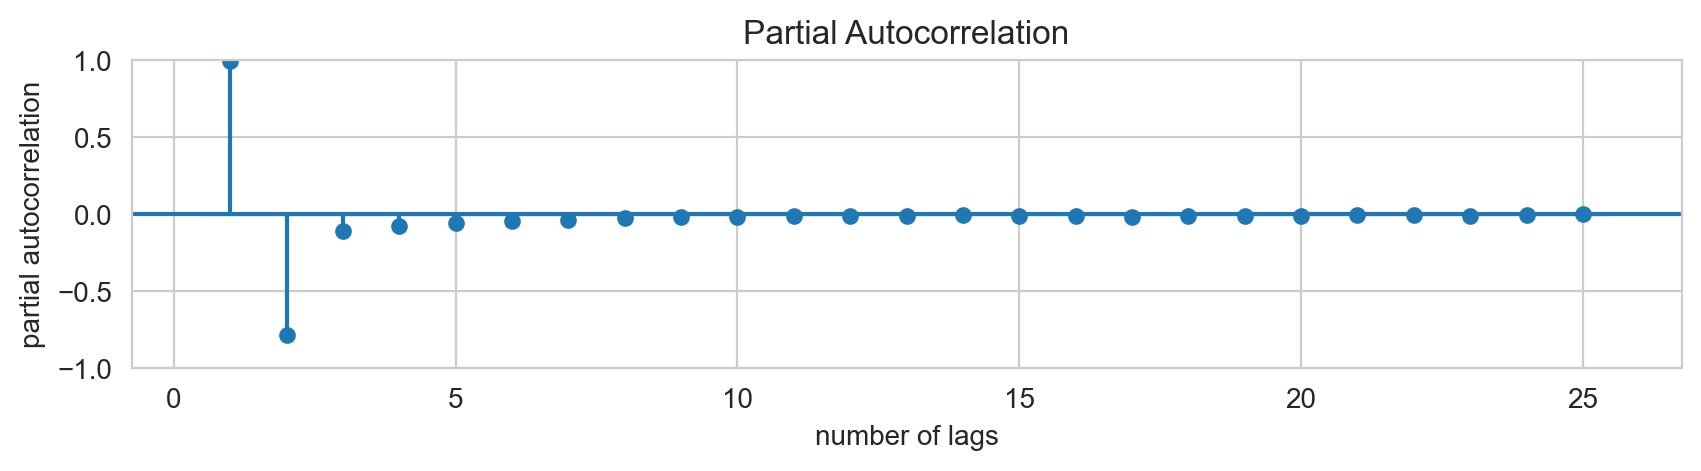

In [307]:
partial_auto_correlation_plot(train['reminder'])

In [308]:
reminder = reminder_sarima_model.predict()
reminder

2023-01-01    7.507659
2023-01-02    7.764457
2023-01-03    7.973807
2023-01-04    8.141328
2023-01-05    8.272005
2023-01-06    8.370263
2023-01-07    8.440026
2023-01-08    8.484776
2023-01-09    8.507600
2023-01-10    8.511236
Freq: D, dtype: float64

In [309]:
sin_ = stepwise_model.predict()
sin_


2023-01-01   -9.250966
2023-01-02   -9.261894
2023-01-03   -9.272544
2023-01-04   -9.282919
2023-01-05   -9.293024
2023-01-06   -9.302861
2023-01-07   -9.312436
2023-01-08   -9.321751
2023-01-09   -9.330812
2023-01-10   -9.339620
Freq: D, dtype: float64

In [310]:
noise = arima_model_noise.predict()
signal_ = stepwise_model.predict()
trend_test = noise.reset_index()[['index']]
trend_test = trend_test.rename(columns={"index": "DATE"})
trend_test_res = trend_model.predict(trend_test)
reminder = reminder_sarima_model.predict()

In [311]:

res = noise  + signal_ + reminder + trend_test_res
res


2023-01-01    14.171098
2023-01-02    12.326741
2023-01-03    11.198047
2023-01-04    10.512237
2023-01-05    10.097499
2023-01-06     9.845980
2023-01-07     9.690300
2023-01-08     9.588657
2023-01-09     9.515382
2023-01-10     9.454946
Freq: D, dtype: float64

In [312]:
test = pd.read_csv('test_temp.csv', index_col=0, skipinitialspace = True, parse_dates = [0])
test

,TEMP
DATE,
2022-12-31,14.5
2023-01-01,14.1
2023-01-02,12.8
2023-01-03,5.1
2023-01-04,6.9
...,...
2023-03-27,3.4
2023-03-28,3.0
2023-03-29,6.6
